In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import joblib
from openpyxl import Workbook  


output_dir = './output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


train_data = pd.read_excel('114.xls', engine='xlrd')  
pre_data = pd.read_excel('pre3.xls', engine='xlrd') 


X_train = train_data[['MD', 'CSDA', 'MH', 'WFL', 'LT']]
y_train = train_data['HFWCZ']

X_pre = pre_data[['MD', 'CSDA', 'MH', 'WFL', 'LT']] 

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


def eval_model(params):
    model = xgb.XGBRegressor(
        max_depth=int(params[0]),
        learning_rate=params[1],
        n_estimators=int(params[2]),
        subsample=params[3],
        colsample_bytree=params[4]
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return mean_squared_error(y_val, y_pred)


class SparrowSearchAlgorithm:
    def __init__(self, pop_size, dim, lb, ub, max_iter, eval_func):
        self.pop_size = pop_size
        self.dim = dim
        self.lb = np.array(lb)
        self.ub = np.array(ub)
        self.max_iter = max_iter
        self.eval_func = eval_func
        self.population = np.random.uniform(self.lb, self.ub, (self.pop_size, self.dim))
        self.fitness = np.zeros(self.pop_size)
        self.global_best = None
        self.global_best_fitness = np.inf

    def run(self):
        for iter in range(self.max_iter):
            for i in range(self.pop_size):
                self.fitness[i] = self.eval_func(self.population[i])
                if self.fitness[i] < self.global_best_fitness:
                    self.global_best_fitness = self.fitness[i]
                    self.global_best = self.population[i].copy()

            # 更新粒子位置
            for i in range(self.pop_size):
                r1 = np.random.rand()
                r2 = np.random.rand()
                if r2 < 0.8:
                    self.population[i] = self.global_best + r1 * (self.ub - self.lb) * np.random.randn(self.dim)
                else:
                    self.population[i] = self.lb + (self.ub - self.lb) * np.random.rand(self.dim)

            self.population = np.clip(self.population, self.lb, self.ub)

        return self.global_best


ssa = SparrowSearchAlgorithm(
    pop_size=10,
    dim=5,
    lb=[3, 0.01, 50, 0.5, 0.5],  
    ub=[10, 0.3, 300, 1.0, 1.0], 
    max_iter=5,
    eval_func=eval_model
)


best_params = ssa.run()
print("best: ", best_params)


model = xgb.XGBRegressor(
    max_depth=int(best_params[0]),
    learning_rate=best_params[1],
    n_estimators=int(best_params[2]),
    subsample=best_params[3],
    colsample_bytree=best_params[4]
)


model.fit(X_train, y_train)


joblib.dump(model, os.path.join(output_dir, 'ssa_xgboost_model.pkl'))


y_train_pred = model.predict(X_train)


y_val_pred = model.predict(X_val)


y_pre_pred = model.predict(X_pre)

print("pre：")
for i, pred in enumerate(y_pre_pred, start=1):
    if 'HFWCZ' in pre_data.columns:  
        true_value = pre_data['HFWCZ'].values[i-1]
        if abs(pred - true_value) / true_value > 0.1:  
            print(f"sam {i}: over，pre = {pred:.4f} m，true = {true_value:.4f} m")
        else:
            print(f"sam {i}: pre = {pred:.4f} m")
    else:
        print(f"sam {i}: pre = {pred:.4f} m")


mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)


print(f"train MSE: {mse_train:.4f}")
print(f"train RMSE: {rmse_train:.4f}")
print(f"train MAE: {mae_train:.4f}")
print(f"train R2: {r2_train:.4f}")


y_pre_true = pre_data['HFWCZ'].values if 'HFWCZ' in pre_data.columns else None  


if y_pre_true is not None:
    mse_pre = mean_squared_error(y_pre_true, y_pre_pred)
    rmse_pre = np.sqrt(mse_pre)
    mae_pre = mean_absolute_error(y_pre_true, y_pre_pred)
    r2_pre = r2_score(y_pre_true, y_pre_pred)


    print(f"pre MSE: {mse_pre:.4f}")
    print(f"pre RMSE: {rmse_pre:.4f}")
    print(f"pre MAE: {mae_pre:.4f}")
    print(f"pre R2: {r2_pre:.4f}")


output_excel = os.path.join(output_dir, 'ssa-xgboost-model_predictions_and_evaluation.xlsx')


wb = Workbook()
ws = wb.active
ws.title = "Predictions and Evaluation"

ws.append(["sam", "true", "pre"])


for i, pred in enumerate(y_pre_pred, start=1):
    true_value = y_pre_true[i - 1] if y_pre_true is not None else None
    ws.append([i, true_value, pred])


eval_sheet = wb.create_sheet(title="Model Evaluation")


eval_sheet.append(["No", "test", "pre"])
eval_sheet.append(["MSE", mse_train, mse_pre if y_pre_true is not None else "N/A"])
eval_sheet.append(["RMSE", rmse_train, rmse_pre if y_pre_true is not None else "N/A"])
eval_sheet.append(["MAE", mae_train, mae_pre if y_pre_true is not None else "N/A"])
eval_sheet.append(["R²", r2_train, r2_pre if y_pre_true is not None else "N/A"])


wb.save(output_excel)

print(f"result {output_excel}")


y_train = np.squeeze(np.array(y_train))  
y_train_pred = np.squeeze(np.array(y_train_pred)) 
y_val = np.squeeze(np.array(y_val))
y_val_pred = np.squeeze(np.array(model.predict(X_val)))  

D:\Anaconda\Anaconda3-2020.07\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


优化后的参数:  [6.25776208e+00 2.22323820e-02 2.63328125e+02 6.49045473e-01
 8.50345650e-01]
预测集的预测结果：
样本 1: 跳过此预测值，预测 = 38.4978 米，真实值 = 44.6500 米
样本 2: 预测的水导裂缝带高度 = 43.7345 米
样本 3: 跳过此预测值，预测 = 48.4503 米，真实值 = 56.8000 米
样本 4: 预测的水导裂缝带高度 = 24.8096 米
训练集 MSE: 19.0732
训练集 RMSE: 4.3673
训练集 MAE: 2.6877
训练集 R2: 0.9839
预测集 MSE: 30.4385
预测集 RMSE: 5.5171
预测集 MAE: 4.6817
预测集 R2: 0.7606
预测结果和模型评估已保存到 ./output\ssa-xgboost-model_predictions_and_evaluation.xlsx


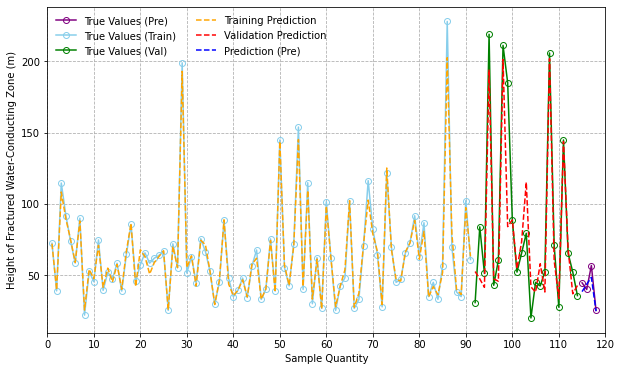

In [2]:

plt.figure(figsize=(10, 6))


pre_index = np.arange(len(y_train) + len(y_val) + 1, len(y_train) + len(y_val) + len(y_pre_pred) + 1)


if y_pre_true is not None:
    plt.plot(pre_index, y_pre_true, 'o-', label="True Values (Pre)", color='purple', markerfacecolor='none')


train_index = np.arange(1, len(y_train) + 1)
plt.plot(train_index, y_train, 'o-', label="True Values (Train)", color='skyblue', markerfacecolor='none')


val_index = np.arange(len(y_train) + 1, len(y_train) + len(y_val) + 1)
plt.plot(val_index, y_val, 'o-', label="True Values (Val)", color='green', markerfacecolor='none')

plt.plot(train_index, y_train_pred, '--', label="Training Prediction", color="#FFA500")
plt.plot(val_index, y_val_pred, '--', label="Validation Prediction", color='red')


plt.plot(pre_index, y_pre_pred, '--', label="Prediction (Pre)", color='blue')


plt.xlim([0, len(y_train) + len(y_val) + len(y_pre_pred)])
plt.xticks(np.arange(0, len(y_train) + len(y_val) + len(y_pre_pred) + 10, 10))
plt.xlabel('Sample Quantity')
plt.ylabel('Height of Fractured Water-Conducting Zone (m)')
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=False, ncol=2)
plt.grid(True, linestyle='--')


plt.savefig(os.path.join(output_dir, 'pre-ssa-xgboost-with-pre-data.png'), dpi=300)
plt.savefig(os.path.join(output_dir, 'pre-ssa-xgboost-with-pre-data.pdf'), dpi=600, format='pdf')
plt.show()